In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./data.txt", sep = '\t')
df.head()

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0


In [4]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

**Normalize the dataset to make the Logistic Regression training smoother**

In [5]:
X_train = (X_train - X_train.mean(axis = 0)) / X_train.std(axis = 0)

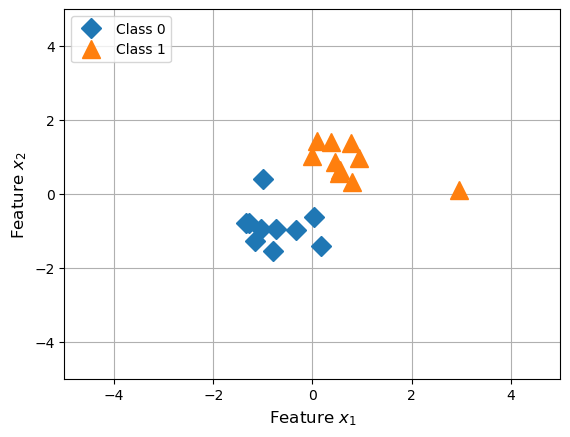

In [6]:
plt.plot(
  X_train[y_train == 0, 0],
  X_train[y_train == 0, 1],
  marker = "D",
  markersize = 10,
  linestyle = "",
  label = "Class 0"
)

plt.plot(
  X_train[y_train == 1, 0],
  X_train[y_train == 1, 1],
  marker = "^",
  markersize = 13,
  linestyle = "",
  label = "Class 1"
)

plt.legend(loc = 2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize = 12)
plt.ylabel("Feature $x_2$", fontsize = 12)

plt.grid()
plt.show()

### **Implement Logistic Regression using Pytorch**

In [7]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.linear = torch.nn.Linear(num_features, 1)

  def forward(self, x):
    logits = self.linear(x) # `logits` is the technical term for weighted sum
    return torch.sigmoid(logits)

In [12]:
torch.manual_seed(200)
model = LogisticRegression(num_features = 2)

In [13]:
x = torch.tensor([1.1, 2.1])

# Disable the construction of computation graph in the background
with torch.no_grad():
  proba = model(x)

proba

tensor([0.7006])

### **Defining a DataLoader**

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class MyDataset(Dataset):
  def __init__(self, x, y):
    self.features = torch.tensor(x, dtype = torch.float32)
    self.labels = torch.tensor(y, dtype = torch.float32)
  
  def __getitem__(self, idx):
    x = self.features[idx]
    y = self.labels[idx]

    return x, y
  
  def __len__(self):
    return self.labels.shape[0]

In [16]:
train_ds = MyDataset(X_train, y_train)

train_loader = DataLoader(
  dataset = train_ds,
  batch_size = 10,
  shuffle = True
)

### **Train the model**

In [22]:
import torch.nn.functional as F

In [23]:
torch.manual_seed(200)

In [24]:
num_epochs = 20
model = LogisticRegression(num_features = 2)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [26]:
for epoch in range(num_epochs):
  model = model.train()

  for batch_idx, (features, labels) in enumerate(train_loader):
    probas = model(features)
    loss = F.binary_cross_entropy(probas, labels.view(probas.shape))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    print(f'Epochs: {epoch + 1:03d}/{num_epochs:03d}'
          f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
          f' | Loss: {loss:.2f}')

Epochs: 001/020 | Batch 000/002 | Loss: 0.69
Epochs: 001/020 | Batch 001/002 | Loss: 0.70
Epochs: 002/020 | Batch 000/002 | Loss: 0.74
Epochs: 002/020 | Batch 001/002 | Loss: 0.60
Epochs: 003/020 | Batch 000/002 | Loss: 0.57
Epochs: 003/020 | Batch 001/002 | Loss: 0.70
Epochs: 004/020 | Batch 000/002 | Loss: 0.58
Epochs: 004/020 | Batch 001/002 | Loss: 0.64
Epochs: 005/020 | Batch 000/002 | Loss: 0.48
Epochs: 005/020 | Batch 001/002 | Loss: 0.69
Epochs: 006/020 | Batch 000/002 | Loss: 0.55
Epochs: 006/020 | Batch 001/002 | Loss: 0.57
Epochs: 007/020 | Batch 000/002 | Loss: 0.46
Epochs: 007/020 | Batch 001/002 | Loss: 0.62
Epochs: 008/020 | Batch 000/002 | Loss: 0.49
Epochs: 008/020 | Batch 001/002 | Loss: 0.54
Epochs: 009/020 | Batch 000/002 | Loss: 0.48
Epochs: 009/020 | Batch 001/002 | Loss: 0.51
Epochs: 010/020 | Batch 000/002 | Loss: 0.48
Epochs: 010/020 | Batch 001/002 | Loss: 0.48
Epochs: 011/020 | Batch 000/002 | Loss: 0.53
Epochs: 011/020 | Batch 001/002 | Loss: 0.39
Epochs: 01

### **Evaluation**

In [27]:
probas

tensor([[0.8014],
        [0.8373],
        [0.7703],
        [0.8583],
        [0.7823],
        [0.3029],
        [0.9138],
        [0.2584],
        [0.2973],
        [0.3152]], grad_fn=<SigmoidBackward0>)

In [28]:
# Convert probability scores to class labels
preds = torch.where(probas > 0.5, 1, 0) # if a probability is > 0.5, return 1 otherwise 0
preds

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]])

In [29]:
labels.view(preds.shape).to(preds.dtype)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]])

In [30]:
def compute_accuracy(model, dataloader):
  model = model.eval()
  correct = 0.0
  total_examples = 0

  for idx, (features, labels) in enumerate(dataloader):
    with torch.no_grad():
      probas = model(features)
    
    pred = torch.where(probas > 0.5, 1, 0)
    lab = labels.view(pred.shape).to(pred.dtype)

    compare = lab == pred
    correct += torch.sum(compare)
    total_examples += len(compare)
  
  return correct / total_examples

In [31]:
train_acc = compute_accuracy(model, train_loader)
print(f'Accuracy: {train_acc * 100}%')

Accuracy: 90.0%


### **Visualization**

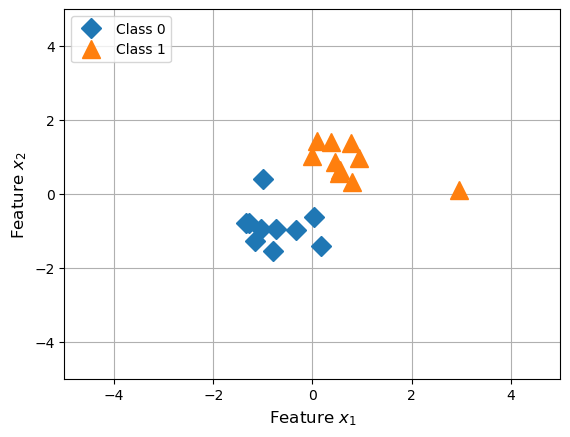

In [32]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)


plt.grid()
plt.show()

In [33]:
def plot_boundary(model):
  w1 = model.linear.weight[0][0].detach()
  w2 = model.linear.weight[0][1].detach()
  b = model.linear.bias[0].detach()

  x1_min = -20
  x2_min = (-(w1 * x1_min) - b) / w2

  x1_max = 20
  x2_max = (-(w1 * x1_max) - b) / w2

  return x1_min, x1_max, x2_min, x2_max

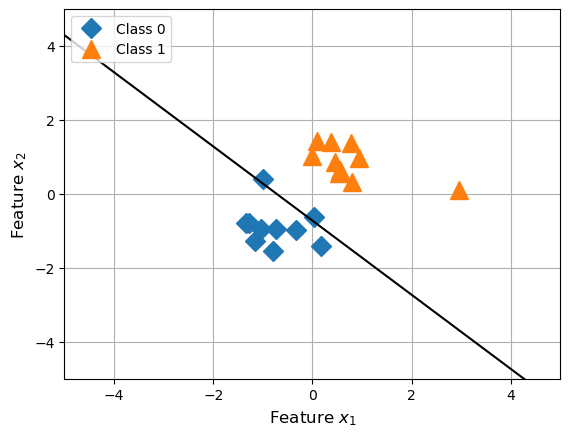

In [34]:
x1_min, x1_max, x2_min, x2_max = plot_boundary(model)

plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.plot([x1_min, x1_max], [x2_min, x2_max], color="k")

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()